#Data Helper

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
workfolder = "MyDrive/HumanLLMTextAnswerAgg/ChatGPT/"
folder = "data/"

import os
os.chdir('/content/drive')
os.chdir(workfolder)
!ls

In [ ]:
import pandas as pd
import numpy as np

def loaddata(labelfilename,gtfilename):
  gtdf = pd.read_csv(gtfilename,sep='\t',encoding='utf-8')

  sentences = gtdf['sentence'].values.tolist()
  truelabels = {}
  for idx,row in gtdf.iterrows():
    truelabels[row['sentence']] = row['trueanswer']

  labeldf = pd.read_csv(labelfilename,sep='\t',encoding='utf-8')

  workers = []
  swlabels = []

  for idx,row in labeldf.iterrows():
    worker = row['worker']
    if worker not in workers:
      workers.append(worker)
    workerid = workers.index(worker)
    sentenceid = sentences.index(row['sentence'])
    label = row['workeranswer'].strip()
    swlabels.append((sentenceid,workerid,label))

  return (workers,sentences,swlabels,truelabels)

def labelformatconversion(workers,sentences,swlabels):
  wlabelidlists = {}
  wsentenceidlists = {}
  for worker in workers:
    wlabelidlists[worker] = []
    wsentenceidlists[worker] = []

  slabelidlists = {}
  sworkeridlists = {}
  for sentence in sentences:
    slabelidlists[sentence] = []
    sworkeridlists[sentence] = []

  labellist = []
  labelidx = 0
  for (sentenceid,workerid,label) in swlabels:
    labellist.append(label)
    sentence = sentences[sentenceid]
    slabelidlists[sentence].append(labelidx)
    sworkeridlists[sentence].append(workerid)
    worker = workers[workerid]
    wlabelidlists[worker].append(labelidx)
    wsentenceidlists[worker].append(sentenceid)
    labelidx += 1

  return (labellist,slabelidlists,sworkeridlists,wlabelidlists,wsentenceidlists)

def truelabelformatonversion(sentences,truelabels):
  truelabellist = []
  for i in range(len(sentences)):
    sentence = sentences[i]
    truelabellist.append(truelabels[sentence])

  return truelabellist

# Universal Sentence Encoder

In [ ]:
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet seaborn

In [ ]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_hub as hub
import os
import re
print('TensorFlow version:', tf.__version__)
print('TensorFlow Hub version:', hub.__version__)

Instructions for updating:
non-resource variables are not supported in the long term


TensorFlow version: 2.15.0
TensorFlow Hub version: 0.16.1


In [ ]:
#module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

# Evaluation Method

In [ ]:
DEFAULT_SIM_TYPE = 'COSINE'
def similarity(embed1, embed2, simtype = DEFAULT_SIM_TYPE):
  if (simtype == 'COSINE'):
    l1 = np.sqrt(np.sum(embed1**2))
    l2 = np.sqrt(np.sum(embed2**2))
    sim = np.inner(embed1,embed2) / (l1*l2)

  return sim

## Embedding

In [ ]:
def evaluationbyEmbedding(sentences, elabels, label_embeddings, truelabels, truelabel_embeddings):
  totalsim = 0
  for sentence in elabels:
    elabel_embedding = label_embeddings[elabels[sentence]]
    truelabel_embedding = truelabel_embeddings[sentences.index(sentence)]
    totalsim += similarity(elabel_embedding,truelabel_embedding)

  #print(len(elabels),totalsim/len(elabels))
  return totalsim/len(elabels)


## GLEU

In [ ]:
import nltk
import nltk.translate.gleu_score as gleu

try:
  nltk.data.find('tokenizers/punkt')
except LookupError:
  nltk.download('punkt')

def evaluationbyGLEU(sentences, labels, elabelidxs, truelabels):
  n = len(sentences)
  sim = 0
  for i in range(n):
    sentence = sentences[i]
    labelidx = elabelidxs[sentence]
    label = labels[labelidx]
    truelabel = truelabels[sentence]
    sim += gleu.sentence_gleu([truelabel.split()], label.split())
  #print(n,sim/n)
  return sim/n

## METEOR

In [ ]:
import nltk
import nltk.translate.meteor_score as meteor

try:
  nltk.data.find('tokenizers/punkt')
except LookupError:
  nltk.download('punkt')

try:
  nltk.data.find('wordnet')
except LookupError:
  nltk.download('wordnet')

def evaluationbyMETEOR(sentences, labels, elabelidxs, truelabels):
  n = len(sentences)
  sim = 0
  for i in range(n):
    sentence = sentences[i]
    labelidx = elabelidxs[sentence]
    label = labels[labelidx]
    truelabel = truelabels[sentence]
    sim += meteor.meteor_score([truelabel.split()], label.split())
  #print(n,sim/n)
  return sim/n

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#Methods

## SMV

In [ ]:
def SMVSelectionAndEvaluationbyEmbedding(sentences, slabelidlists, label_embeddings, truelabel_embeddings):
  total_sim = 0
  for i in range(len(sentences)):
    sentence = sentences[i]
    truelabel_embedding = truelabel_embeddings[sentences.index(sentence)]
    slabel_embeddings = label_embeddings[slabelidlists[sentence]]
    onetotal_sim = 0
    for label_embedding in slabel_embeddings:
      onetotal_sim += similarity(label_embedding,truelabel_embedding)
    total_sim += onetotal_sim/len(slabel_embeddings)

  #print(len(sentences),total_sim/len(sentences))
  return total_sim/len(sentences)

In [ ]:
def SMVSelectionAndEvaluationbyGLEU(sentences, slabelidlists, labels, truelabels):
  total_sim = 0
  for i in range(len(sentences)):
    sentence = sentences[i]
    truelabel = truelabels[sentences.index(sentence)]
    slabels = labels[slabelidlists[sentence]]
    onetotal_sim = 0
    for label in slabels:
      onetotal_sim += gleu.sentence_gleu([truelabel.split()], label.split())
    total_sim += onetotal_sim/len(slabels)

  #print(len(sentences),total_sim/len(sentences))
  return total_sim/len(sentences)

In [ ]:
def SMVSelectionAndEvaluationbyMETEOR(sentences, slabelidlists, labels, truelabels):
  total_sim = 0
  for i in range(len(sentences)):
    sentence = sentences[i]
    truelabel = truelabels[sentences.index(sentence)]
    slabels = labels[slabelidlists[sentence]]
    onetotal_sim = 0
    for label in slabels:
      onetotal_sim += meteor.meteor_score([truelabel.split()], label.split())
    total_sim += onetotal_sim/len(slabels)

  #print(len(sentences),total_sim/len(sentences))
  return total_sim/len(sentences)

##SMS

In [ ]:
def SMSSelectionOne(labelidlist, slabel_embeddings):
  labelnum = len(slabel_embeddings)
  simmat = np.zeros((labelnum,labelnum))
  for i in range(labelnum):
    for j in range(labelnum):
      simmat[i][j] = similarity(slabel_embeddings[i],slabel_embeddings[j])

  sim = np.sum(simmat,axis=1)
  maxlabelidx = np.argmax(sim)
  return labelidlist[maxlabelidx]

def SMSSelection(sentences, slabelidlists, label_embeddings):
  elabels = {}
  for i in range(len(sentences)):
    sentence = sentences[i]
    slabel_embeddings = label_embeddings[slabelidlists[sentence]]
    elabel = SMSSelectionOne(slabelidlists[sentence], slabel_embeddings)
    elabels[sentence] = elabel
  return elabels

## RASA

In [ ]:
from scipy.stats import chi2

def RASAInference(workers, sentences, slabelidlists, sworkeridlists, wlabelidlists, wsentenceidlists, label_embeddings):
  max_ite = 1000

  # initilizing the estimated embedding by using SMV
  estimated_embeddings = []
  for i in range(len(sentences)):
    sentence = sentences[i]
    slabel_embeddings = label_embeddings[slabelidlists[sentence]]
    estimated_embeddings.append(np.mean(slabel_embeddings, axis=0))
  estimated_embeddings = np.asarray(estimated_embeddings)

  w_num = len(workers)
  reliability = np.zeros(w_num)
  s_num = len(sentences)

  ite = 0
  eb_change = 1
  while (ite <= max_ite) and (eb_change > 0.0000001):
    old_estimated_embeddings = np.copy(estimated_embeddings)

    # compute reliability
    for j in range(w_num):
      worker = workers[j]
      westimated_embeddings = estimated_embeddings[wsentenceidlists[worker]]
      nw = len(wsentenceidlists[worker])
      chiw = chi2.isf(q=0.025, df=nw)
      wlabelidlist = wlabelidlists[worker]
      wlabel_embeddings = label_embeddings[wlabelidlist]
      diff_embedding = (westimated_embeddings - wlabel_embeddings)
      if (np.sum(diff_embedding) == 0):
        reliability[j] = 1
      else:
        reliability[j] = chiw / np.sum(diff_embedding*diff_embedding)

    # compute estimated embeddings
    for i in range(s_num):
      sentence = sentences[i]
      slabelidlist = slabelidlists[sentence]
      slabel_embeddings = label_embeddings[slabelidlist]
      sworkeridlist = sworkeridlists[sentence]
      sworkeridrelaiblity = reliability[sworkeridlist]
      for j in range(len(sworkeridrelaiblity)):
        slabel_embeddings[j] = slabel_embeddings[j] * sworkeridrelaiblity[j]
      estimated_embeddings[i] = np.sum(slabel_embeddings, axis=0) / np.sum(sworkeridrelaiblity)

    eb_diff = (estimated_embeddings - old_estimated_embeddings)
    eb_change = np.sum(eb_diff * eb_diff)
    ite += 1

  return (estimated_embeddings,reliability)

def RASASelectionOne(estimated_embedding, labelidlist, label_embeddings):
  slabel_num = len(labelidlist)
  slabel_embeddings = label_embeddings[labelidlist]
  simvec = np.zeros(slabel_num)
  for k in range(slabel_num):
    simvec[k] = similarity(estimated_embedding,slabel_embeddings[k])
  maxlabelidx = np.argmax(simvec)
  return labelidlist[maxlabelidx]

def RASASelection(sentences, slabelidlists, label_embeddings, estimated_embeddings):
  elabels = {}
  for i in range(len(sentences)):
      sentence = sentences[i]
      slabelidlist = slabelidlists[sentence]
      elabel = RASASelectionOne(estimated_embeddings[i], slabelidlist, label_embeddings)
      elabels[sentence] = elabel
  return elabels

##Optimal

In [ ]:
def OptimalSelectionAndEvaluationbyEmbedding(sentences, slabelidlists, label_embeddings, truelabel_embeddings):
  total_sim = 0
  for i in range(len(sentences)):
    sentence = sentences[i]
    truelabel_embedding = truelabel_embeddings[sentences.index(sentence)]
    slabel_embeddings = label_embeddings[slabelidlists[sentence]]
    ns = len(slabel_embeddings)
    sims = np.zeros(ns)
    for k in range(ns):
      label_embedding = slabel_embeddings[k]
      sims[k] = similarity(label_embedding,truelabel_embedding)
    maxsim = np.max(sims)
    total_sim += maxsim
  #print(len(sentences),total_sim/len(sentences))
  return total_sim/len(sentences)

In [ ]:
def OptimalSelectionAndEvaluationbyGLEU(sentences, slabelidlists, labels, truelabels):
  total_sim = 0
  for i in range(len(sentences)):
    sentence = sentences[i]
    truelabel = truelabels[sentences.index(sentence)]
    slabels = labels[slabelidlists[sentence]]
    ns = len(slabels)
    sims = np.zeros(ns)
    for k in range(ns):
      label = slabels[k]
      sims[k] = gleu.sentence_gleu([truelabel.split()], label.split())
    maxsim = np.max(sims)
    total_sim += maxsim
  #print(len(sentences),total_sim/len(sentences))
  return total_sim/len(sentences)

In [ ]:
def OptimalSelectionAndEvaluationbyMETEOR(sentences, slabelidlists, labels, truelabels):
  total_sim = 0
  for i in range(len(sentences)):
    sentence = sentences[i]
    truelabel = truelabels[sentences.index(sentence)]
    slabels = labels[slabelidlists[sentence]]
    ns = len(slabels)
    sims = np.zeros(ns)
    for k in range(ns):
      label = slabels[k]
      sims[k] = meteor.meteor_score([truelabel.split()], label.split())
    maxsim = np.max(sims)
    total_sim += maxsim
  #print(len(sentences),total_sim/len(sentences))
  return total_sim/len(sentences)

#Experiments

In [ ]:
def run(labelfilename,gtfilename):
  # labellist: all labels for all sentences by all workers
  # slabelidlists: label id list for each sentence
  # sworkeridlists: worker id list for each sentence
  # wlabelidlists: label id list for each worker
  # wsentenceidlists: sentence id list for each worker
  (workers,sentences,swlabels,truelabels) = loaddata(labelfilename,gtfilename)
  (labellist,slabelidlists,sworkeridlists,wlabelidlists,wsentenceidlists) = labelformatconversion(workers,sentences,swlabels)
  (truelabellist) = truelabelformatonversion(sentences,truelabels)

  # label_embeddings: embeddings of all labels of workers
  # truelabel_embeddings: embeddings of all true labels

  # Import the Universal Sentence Encoder's TF Hub module
  #embed = hub.Module(module_url)
  embed = hub.load(module_url)

  # Reduce logging output.
  tf.logging.set_verbosity(tf.logging.ERROR)

  with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    label_embeddings = session.run(embed(labellist))

  with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    truelabel_embeddings = session.run(embed(truelabellist))

  # print('Optimal')
  perf_opt_embedding = OptimalSelectionAndEvaluationbyEmbedding(sentences, slabelidlists, label_embeddings, truelabel_embeddings)
  perf_opt_gleu = OptimalSelectionAndEvaluationbyGLEU(sentences, slabelidlists, np.asarray(labellist), np.asarray(truelabellist))
  perf_opt_meteor = OptimalSelectionAndEvaluationbyMETEOR(sentences, slabelidlists, np.asarray(labellist), np.asarray(truelabellist))

  # print('SMV')
  perf_smv_embedding = SMVSelectionAndEvaluationbyEmbedding(sentences, slabelidlists, label_embeddings, truelabel_embeddings)
  perf_smv_gleu = SMVSelectionAndEvaluationbyGLEU(sentences, slabelidlists, np.asarray(labellist), np.asarray(truelabellist))
  perf_smv_meteor = SMVSelectionAndEvaluationbyMETEOR(sentences, slabelidlists, np.asarray(labellist), np.asarray(truelabellist))


  # print('SMS')
  LSNNelabels = SMSSelection(sentences, slabelidlists, label_embeddings)
  perf_sms_embedding = evaluationbyEmbedding(sentences, LSNNelabels, label_embeddings, truelabels, truelabel_embeddings)
  perf_sms_gleu = evaluationbyGLEU(sentences, np.asarray(labellist), LSNNelabels, truelabels)
  perf_sms_meteor = evaluationbyMETEOR(sentences, np.asarray(labellist), LSNNelabels, truelabels)

  # print('RASA')
  (estimated_embeddings, reliability) = RASAInference(workers, sentences, slabelidlists, sworkeridlists, wlabelidlists, wsentenceidlists, label_embeddings)
  LSCATDelabels = RASASelection(sentences, slabelidlists, label_embeddings, estimated_embeddings)
  perf_rasa_embedding = evaluationbyEmbedding(sentences, LSCATDelabels, label_embeddings, truelabels, truelabel_embeddings)
  perf_rasa_gleu = evaluationbyGLEU(sentences, np.asarray(labellist), LSCATDelabels, truelabels)
  perf_rasa_meteor = evaluationbyMETEOR(sentences, np.asarray(labellist), LSCATDelabels, truelabels)

  print("Evaluation,SMV,SMS,RASA,Optimal")
  print("Embedding,%.4f,%.4f,%.4f,%.4f" % (perf_smv_embedding,perf_sms_embedding,perf_rasa_embedding,perf_opt_embedding))
  print("GLEU,%.4f,%.4f,%.4f,%.4f" % (perf_smv_gleu,perf_sms_gleu,perf_rasa_gleu,perf_opt_gleu))
  print("METEOR,%.4f,%.4f,%.4f,%.4f" % (perf_smv_meteor,perf_sms_meteor,perf_rasa_meteor,perf_opt_meteor))

## Crowd Only

In [ ]:
# J1
labelfilename = folder + 'CrowdWSA2019_J1_label_anonymous.tsv'
gtfilename = folder + 'CrowdWSA2019_J1_gt.tsv'

print("Data:J1")
run(labelfilename,gtfilename)

Data:J1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.6732,0.7426,0.7414,0.8475
GLEU,0.1930,0.2489,0.2537,0.4990
METEOR,0.3861,0.4666,0.4745,0.7077


In [ ]:
# T1
labelfilename = folder + 'CrowdWSA2019_T1_label_anonymous.tsv'
gtfilename = folder + 'CrowdWSA2019_T1_gt.tsv'

print("Data:T1")
run(labelfilename,gtfilename)

Data:T1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7245,0.7935,0.8020,0.8750
GLEU,0.1740,0.2310,0.2376,0.3698
METEOR,0.3786,0.4548,0.4718,0.6073


In [ ]:
# T2
labelfilename = folder + 'CrowdWSA2019_T2_label_anonymous.tsv'
gtfilename = folder + 'CrowdWSA2019_T2_gt.tsv'

print("Data:T2")
run(labelfilename,gtfilename)

Data:T2
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7105,0.7860,0.7935,0.8669
GLEU,0.1616,0.2189,0.2340,0.3637
METEOR,0.3604,0.4426,0.4653,0.6034


## HumanAgg Only

In [ ]:
# J1
labelfilename = folder + 'CrowdWSA2019_J1_label_anonymous_humanagg.tsv'
gtfilename = folder + 'CrowdWSA2019_J1_gt.tsv'

print("Data:J1")
run(labelfilename,gtfilename)

Data:J1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.6983,0.7360,0.7162,0.7963
GLEU,0.2260,0.2740,0.2397,0.3835
METEOR,0.4397,0.4912,0.4524,0.6200


In [ ]:
# T1
labelfilename = folder + 'CrowdWSA2019_T1_label_anonymous_humanagg.tsv'
gtfilename = folder + 'CrowdWSA2019_T1_gt.tsv'

print("Data:T1")
run(labelfilename,gtfilename)

Data:T1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7430,0.7851,0.7761,0.8278
GLEU,0.1819,0.2074,0.2007,0.2827
METEOR,0.3927,0.4330,0.4272,0.5198


In [ ]:
# T2
labelfilename = folder + 'CrowdWSA2019_T2_label_anonymous_humanagg.tsv'
gtfilename = folder + 'CrowdWSA2019_T2_gt.tsv'

print("Data:T2")
run(labelfilename,gtfilename)

Data:T2
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7282,0.7681,0.7468,0.8145
GLEU,0.1769,0.2087,0.1952,0.2963
METEOR,0.3746,0.4238,0.4083,0.5315


## ChatGPT Only

In [ ]:
# J1
labelfilename = folder + 'CrowdWSA2019_J1_label_9temperature_trial0_gpt-4-turbo-preview.tsv'
gtfilename = folder + 'CrowdWSA2019_J1_gt.tsv'

print("Data:J1")
run(labelfilename,gtfilename)

Data:J1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7300,0.7351,0.7341,0.7786
GLEU,0.2686,0.2806,0.2721,0.3520
METEOR,0.5007,0.5129,0.5077,0.5961


1temperature_trial0_gpt-4-turbo-preview

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7317,0.7317,0.7317,0.7317

GLEU,0.2740,0.2740,0.2740,0.2740

METEOR,0.5070,0.5070,0.5070,0.5070

3temperature_trial0_gpt-4-turbo-preview

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7287,0.7321,0.7317,0.7531

GLEU,0.2738,0.2805,0.2740,0.3106

METEOR,0.5051,0.5127,0.5070,0.5489

5temperature_trial0_gpt-4-turbo-preview

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7313,0.7332,0.7317,0.7630

GLEU,0.2729,0.2770,0.2740,0.3251

METEOR,0.5049,0.5110,0.5070,0.5670

7temperature_trial0_gpt-4-turbo-preview

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7320,0.7333,0.7317,0.7693

GLEU,0.2720,0.2783,0.2740,0.3337

METEOR,0.5043,0.5110,0.5070,0.5750

In [ ]:
# T1
labelfilename = folder + 'CrowdWSA2019_T1_label_9temperature_trial0_gpt-4-turbo-preview.tsv'
gtfilename = folder + 'CrowdWSA2019_T1_gt.tsv'

print("Data:T1")
run(labelfilename,gtfilename)

Data:T1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7725,0.7767,0.7766,0.8098
GLEU,0.2141,0.2144,0.2173,0.2664
METEOR,0.4236,0.4253,0.4279,0.4813


1temperature_trial0_gpt-4-turbo-preview

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7762,0.7762,0.7762,0.7762

GLEU,0.2170,0.2170,0.2170,0.2170

METEOR,0.4275,0.4275,0.4275,0.4275

3temperature_trial0_gpt-4-turbo-preview

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7763,0.7781,0.7762,0.7934

GLEU,0.2154,0.2180,0.2170,0.2399

METEOR,0.4262,0.4280,0.4275,0.4550

5temperature_trial0_gpt-4-turbo-preview

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7786,0.7807,0.7762,0.7997

GLEU,0.2184,0.2238,0.2170,0.2497

METEOR,0.4294,0.4351,0.4275,0.4647

7temperature_trial0_gpt-4-turbo-preview

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7760,0.7762,0.7762,0.8026

GLEU,0.2155,0.2154,0.2170,0.2519

METEOR,0.4243,0.4257,0.4275,0.4657

In [ ]:
# T2
labelfilename = folder + 'CrowdWSA2019_T2_label_9temperature_trial0_gpt-4-turbo-preview.tsv'
gtfilename = folder + 'CrowdWSA2019_T2_gt.tsv'

print("Data:T2")
run(labelfilename,gtfilename)

Data:T2
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7646,0.7704,0.7681,0.8026
GLEU,0.2118,0.2155,0.2118,0.2620
METEOR,0.4245,0.4300,0.4271,0.4840


1temperature_trial0_gpt-4-turbo-preview

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7673,0.7673,0.7673,0.7673

GLEU,0.2095,0.2095,0.2095,0.2095

METEOR,0.4287,0.4287,0.4287,0.4287

3temperature_trial0_gpt-4-turbo-preview

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7659,0.7696,0.7679,0.7865

GLEU,0.2122,0.2121,0.2233,0.2419

METEOR,0.4266,0.4298,0.4407,0.4623

5temperature_trial0_gpt-4-turbo-preview

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7651,0.7725,0.7673,0.7899

GLEU,0.2136,0.2122,0.2095,0.2504

METEOR,0.4278,0.4330,0.4287,0.4703

7temperature_trial0_gpt-4-turbo-preview

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7658,0.7706,0.7711,0.7940

GLEU,0.2147,0.2147,0.2175,0.2546

METEOR,0.4287,0.4301,0.4337,0.4743

## Crowd + HumanAgg

In [ ]:
# J1
labelfilename = folder + 'CrowdWSA2019_J1_label_anonymous_crowd+humanagg.tsv'
gtfilename = folder + 'CrowdWSA2019_J1_gt.tsv'

print("Data:J1")
run(labelfilename,gtfilename)

Data:J1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.6815,0.7516,0.7460,0.8646
GLEU,0.2040,0.2873,0.2713,0.5431
METEOR,0.4040,0.5092,0.4946,0.7444


In [ ]:
# T1
labelfilename = folder + 'CrowdWSA2019_T1_label_anonymous_crowd+humanagg.tsv'
gtfilename = folder + 'CrowdWSA2019_T1_gt.tsv'

print("Data:T1")
run(labelfilename,gtfilename)

Data:T1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7306,0.7965,0.7976,0.8841
GLEU,0.1767,0.2257,0.2307,0.3851
METEOR,0.3833,0.4528,0.4564,0.6229


In [ ]:
# T2
labelfilename = folder + 'CrowdWSA2019_T2_label_anonymous_crowd+humanagg.tsv'
gtfilename = folder + 'CrowdWSA2019_T2_gt.tsv'

print("Data:T2")
run(labelfilename,gtfilename)

Data:T2
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7164,0.7885,0.7822,0.8747
GLEU,0.1667,0.2369,0.2341,0.3847
METEOR,0.3651,0.4507,0.4551,0.6197


## Crowd + ChatGPT

In [ ]:
# J1
labelfilename = folder + 'CrowdWSA2019_J1_label_anonymous_crowd+9chatgpt.tsv'
gtfilename = folder + 'CrowdWSA2019_J1_gt.tsv'

print("Data:J1")
run(labelfilename,gtfilename)

Data:J1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7001,0.7425,0.7368,0.8595
GLEU,0.2289,0.2834,0.2752,0.5322
METEOR,0.4405,0.5090,0.5073,0.7382


1temperature_trial0_gpt-4-turbo-preview

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.6785,0.7492,0.7443,0.8522

GLEU,0.2004,0.2694,0.2697,0.5142

METEOR,0.3971,0.4965,0.4935,0.7226

3temperature_trial0_gpt-4-turbo-preview

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.6860,0.7435,0.7380,0.8552

GLEU,0.2117,0.2720,0.2800,0.5235

METEOR,0.4136,0.4987,0.5089,0.7293

5temperature_trial0_gpt-4-turbo-preview

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.6926,0.7427,0.7356,0.8566

GLEU,0.2196,0.2846,0.2742,0.5257

METEOR,0.4258,0.5166,0.5076,0.7324

7temperature_trial0_gpt-4-turbo-preview

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.6975,0.7413,0.7360,0.8578

GLEU,0.2255,0.2823,0.2737,0.5279

METEOR,0.4349,0.5122,0.5058,0.7347

In [ ]:
# T1
labelfilename = folder + 'CrowdWSA2019_T1_label_anonymous_crowd+9chatgpt.tsv'
gtfilename = folder + 'CrowdWSA2019_T1_gt.tsv'

print("Data:T1")
run(labelfilename,gtfilename)

Data:T1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7472,0.7858,0.7780,0.8825
GLEU,0.1930,0.2266,0.2186,0.3864
METEOR,0.3999,0.4458,0.4355,0.6161


1temperature_trial0_gpt-4-turbo-preview

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7292,0.7904,0.7943,0.8797

GLEU,0.1779,0.2235,0.2223,0.3802

METEOR,0.3830,0.4559,0.4525,0.6117

3temperature_trial0_gpt-4-turbo-preview

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7364,0.7919,0.7794,0.8812

GLEU,0.1836,0.2274,0.2193,0.3826

METEOR,0.3896,0.4495,0.4363,0.6126

5temperature_trial0_gpt-4-turbo-preview

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7425,0.7894,0.7793,0.8815

GLEU,0.1888,0.2334,0.2218,0.3831

METEOR,0.3955,0.4538,0.4378,0.6136

7temperature_trial0_gpt-4-turbo-preview

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7457,0.7854,0.7772,0.8815

GLEU,0.1911,0.2263,0.2186,0.3831

METEOR,0.3974,0.4466,0.4349,0.6136

In [ ]:
# T2
labelfilename = folder + 'CrowdWSA2019_T2_label_anonymous_crowd+9chatgpt.tsv'
gtfilename = folder + 'CrowdWSA2019_T2_gt.tsv'

print("Data:T2")
run(labelfilename,gtfilename)

Data:T2
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7361,0.7822,0.7729,0.8708
GLEU,0.1854,0.2231,0.2178,0.3786
METEOR,0.3907,0.4462,0.4384,0.6077


1temperature_trial0_gpt-4-turbo-preview

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7156,0.7889,0.7985,0.8689

GLEU,0.1659,0.2280,0.2368,0.3696

METEOR,0.3666,0.4565,0.4671,0.6062

3temperature_trial0_gpt-4-turbo-preview

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7233,0.7875,0.7815,0.8697

GLEU,0.1733,0.2310,0.2243,0.3743

METEOR,0.3757,0.4573,0.4475,0.6072

5temperature_trial0_gpt-4-turbo-preview

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7287,0.7856,0.7744,0.8697

GLEU,0.1789,0.2293,0.2194,0.3771

METEOR,0.3829,0.4523,0.4402,0.607

7temperature_trial0_gpt-4-turbo-preview

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7333,0.7862,0.7723,0.8707

GLEU,0.1835,0.2248,0.2178,0.3782

METEOR,0.3885,0.4504,0.4383,0.6077

## HumanAgg + ChatGPT

In [ ]:
# J1
labelfilename = folder + 'CrowdWSA2019_J1_label_anonymous_humanagg+9chatgpt.tsv'
gtfilename = folder + 'CrowdWSA2019_J1_gt.tsv'

print("Data:J1")
run(labelfilename,gtfilename)

Data:J1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7187,0.7384,0.7344,0.8263
GLEU,0.2534,0.2823,0.2751,0.4508
METEOR,0.4789,0.5121,0.5088,0.6844


1temperature_trial0_gpt-4-turbo-preview

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7039,0.7445,0.7236,0.8107

GLEU,0.2340,0.2822,0.2512,0.4197

METEOR,0.4509,0.5025,0.4630,0.6543

3temperature_trial0_gpt-4-turbo-preview

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7097,0.7437,0.7340,0.8175

GLEU,0.2439,0.2949,0.2728,0.4336

METEOR,0.4642,0.5219,0.4932,0.6681

5temperature_trial0_gpt-4-turbo-preview

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7148,0.7413,0.7336,0.8212

GLEU,0.2494,0.2962,0.2732,0.4389

METEOR,0.4723,0.5248,0.5064,0.6736

7temperature_trial0_gpt-4-turbo-preview

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7180,0.7383,0.7349,0.8235

GLEU,0.2528,0.2872,0.2744,0.4418

METEOR,0.4774,0.5172,0.5087,0.6764

In [ ]:
# T1
labelfilename = folder + 'CrowdWSA2019_T1_label_anonymous_humanagg+9chatgpt.tsv'
gtfilename = folder + 'CrowdWSA2019_T1_gt.tsv'

print("Data:T1")
run(labelfilename,gtfilename)

Data:T1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7619,0.7824,0.7755,0.8469
GLEU,0.2026,0.2221,0.2133,0.3158
METEOR,0.4126,0.4374,0.4253,0.5517


1temperature_trial0_gpt-4-turbo-preview

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7485,0.7927,0.7802,0.8395

GLEU,0.1877,0.2198,0.2081,0.2993

METEOR,0.3985,0.4405,0.4305,0.5384

3temperature_trial0_gpt-4-turbo-preview

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7554,0.7847,0.7854,0.8436

GLEU,0.1945,0.2201,0.2207,0.3083

METEOR,0.4052,0.4332,0.4361,0.5463

5temperature_trial0_gpt-4-turbo-preview

Data:T1
Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7608,0.7854,0.7807,0.8442

GLEU,0.2001,0.2249,0.2218,0.3101

METEOR,0.4110,0.4406,0.4366,0.5492

7temperature_trial0_gpt-4-turbo-preview

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7622,0.7831,0.7778,0.8448

GLEU,0.2015,0.2220,0.2170,0.3101

METEOR,0.4111,0.4373,0.4302,0.5492

In [ ]:
# T2
labelfilename = folder + 'CrowdWSA2019_T2_label_anonymous_humanagg+9chatgpt.tsv'
gtfilename = folder + 'CrowdWSA2019_T2_gt.tsv'

print("Data:T2")
run(labelfilename,gtfilename)

Data:T2
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7516,0.7740,0.7727,0.8420
GLEU,0.1993,0.2192,0.2192,0.3324
METEOR,0.4067,0.4390,0.4400,0.5654


1temperature_trial0_gpt-4-turbo-preview

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7347,0.7701,0.7520,0.8296

GLEU,0.1823,0.2183,0.2015,0.3130

METEOR,0.3836,0.4316,0.4155,0.5549

3temperature_trial0_gpt-4-turbo-preview

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7423,0.7796,0.7722,0.8339

GLEU,0.1901,0.2392,0.2297,0.3215

METEOR,0.3941,0.4545,0.4469,0.5583

5temperature_trial0_gpt-4-turbo-preview

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7467,0.7712,0.7728,0.8352

GLEU,0.1953,0.2253,0.2252,0.3251

METEOR,0.4012,0.4423,0.4482,0.5588

7temperature_trial0_gpt-4-turbo-preview

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7502,0.7749,0.7737,0.8368

GLEU,0.1989,0.2178,0.2202,0.3281

METEOR,0.4061,0.4400,0.4427,0.5602

## Crowd + HumanAgg + ChatGPT

In [ ]:
# J1
labelfilename = folder + 'CrowdWSA2019_J1_label_anonymous_crowd+humanagg+9chatgpt.tsv'
gtfilename = folder + 'CrowdWSA2019_J1_gt.tsv'

print("Data:J1")
run(labelfilename,gtfilename)

Data:J1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.6997,0.7451,0.7353,0.8725
GLEU,0.2282,0.2913,0.2757,0.5656
METEOR,0.4403,0.5203,0.5053,0.7630


1temperature_trial0_gpt-4-turbo-preview

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.6847,0.7519,0.7484,0.8674

GLEU,0.2084,0.2888,0.2841,0.5517

METEOR,0.4104,0.5111,0.5051,0.7515

3temperature_trial0_gpt-4-turbo-preview

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.6894,0.7505,0.7464,0.8697

GLEU,0.2156,0.2904,0.2896,0.5595

METEOR,0.4209,0.5154,0.5164,0.7566

5temperature_trial0_gpt-4-turbo-preview

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.6940,0.7484,0.7410,0.8703

GLEU,0.2212,0.3003,0.2812,0.5611

METEOR,0.4293,0.5240,0.5147,0.7589

7temperature_trial0_gpt-4-turbo-preview

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.6976,0.7458,0.7366,0.8714

GLEU,0.2256,0.2912,0.2768,0.5629

METEOR,0.4360,0.5234,0.5064,0.7603

In [ ]:
# T1
labelfilename = folder + 'CrowdWSA2019_T1_label_anonymous_crowd+humanagg+9chatgpt.tsv'
gtfilename = folder + 'CrowdWSA2019_T1_gt.tsv'

print("Data:T1")
run(labelfilename,gtfilename)

Data:T1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7463,0.7880,0.7810,0.8890
GLEU,0.1907,0.2254,0.2220,0.3961
METEOR,0.3984,0.4496,0.4409,0.6281


1temperature_trial0_gpt-4-turbo-preview

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7335,0.7946,0.7998,0.8877

GLEU,0.1792,0.2276,0.2391,0.3932

METEOR,0.3860,0.4501,0.4668,0.6271

3temperature_trial0_gpt-4-turbo-preview

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7382,0.7939,0.8007,0.8882

GLEU,0.1831,0.2315,0.2377,0.3932

METEOR,0.3904,0.4560,0.4621,0.6271

5temperature_trial0_gpt-4-turbo-preview

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7426,0.7993,0.7890,0.8883

GLEU,0.1871,0.2329,0.2307,0.3937

METEOR,0.3948,0.4609,0.4495,0.6272

7temperature_trial0_gpt-4-turbo-preview

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7451,0.7886,0.7796,0.8883

GLEU,0.1890,0.2230,0.2216,0.3937

METEOR,0.3963,0.4489,0.4385,0.6272

In [ ]:
# T2
labelfilename = folder + 'CrowdWSA2019_T2_label_anonymous_crowd+humanagg+9chatgpt.tsv'
gtfilename = folder + 'CrowdWSA2019_T2_gt.tsv'

print("Data:T2")
run(labelfilename,gtfilename)

Data:T2
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7345,0.7870,0.7819,0.8775
GLEU,0.1836,0.2351,0.2292,0.3941
METEOR,0.3874,0.4568,0.4529,0.6229


1temperature_trial0_gpt-4-turbo-preview

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7196,0.7920,0.7840,0.8759

GLEU,0.1694,0.2479,0.2377,0.3866

METEOR,0.3691,0.4675,0.4620,0.6225

3temperature_trial0_gpt-4-turbo-preview

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7246,0.7908,0.7867,0.8764

GLEU,0.1743,0.2326,0.2359,0.3902

METEOR,0.3754,0.4616,0.4626,0.6227

5temperature_trial0_gpt-4-turbo-preview

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7286,0.7851,0.7824,0.8764

GLEU,0.1784,0.2309,0.2372,0.3925

METEOR,0.3808,0.4606,0.4626,0.6228

7temperature_trial0_gpt-4-turbo-preview

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7321,0.7826,0.7814,0.8774

GLEU,0.1820,0.2324,0.2252,0.3936

METEOR,0.3853,0.4548,0.4498,0.6229

### Figure: Different number of ChatGPT Aggregator

#### J1 GLUE

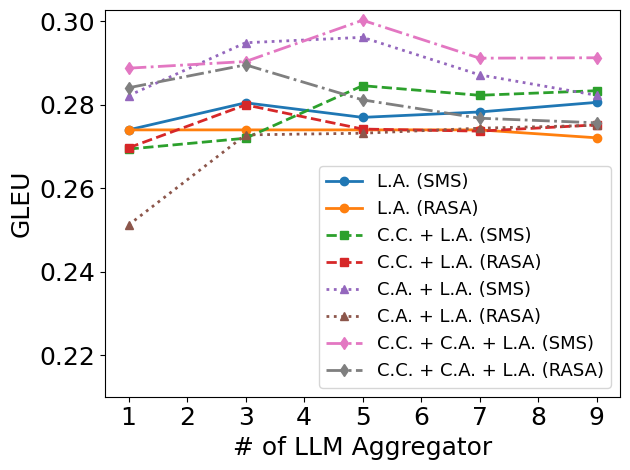

In [ ]:
import matplotlib.pyplot as plt

# Given data
x_values = [1, 3, 5, 7, 9]

# Y values for different categories
la_sms = [0.2740, 0.2805, 0.2770, 0.2783, 0.2806]
la_rasa = [0.2740, 0.2740, 0.2740, 0.2740, 0.2721]
cc_la_sms = [0.2694, 0.2720, 0.2846, 0.2823, 0.2834]
cc_la_rasa = [0.2697, 0.2800, 0.2742, 0.2737, 0.2752]
ca_la_sms = [0.2822, 0.2949, 0.2962, 0.2872, 0.2823]
ca_la_rasa = [0.2512, 0.2728, 0.2732, 0.2744, 0.2751]
cc_ca_la_sms = [0.2888, 0.2904, 0.3003, 0.2912, 0.2913]
cc_ca_la_rasa = [0.2841, 0.2896, 0.2812, 0.2768, 0.2757]

# Create line plots for each category with specified markers and line styles
plt.plot(x_values, la_sms, label='L.A. (SMS)', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, la_rasa, label='L.A. (RASA)', marker='o', linestyle='-', linewidth=2)  # Same marker and line style as 'L.A. (SMS)'
plt.plot(x_values, cc_la_sms, label='C.C. + L.A. (SMS)', marker='s', linestyle='--', linewidth=2)
plt.plot(x_values, cc_la_rasa, label='C.C. + L.A. (RASA)', marker='s', linestyle='--', linewidth=2)  # Same marker and line style as 'C.C. + L.A. (SMS)'
plt.plot(x_values, ca_la_sms, label='C.A. + L.A. (SMS)', marker='^', linestyle=':', linewidth=2)
plt.plot(x_values, ca_la_rasa, label='C.A. + L.A. (RASA)', marker='^', linestyle=':', linewidth=2)  # Same marker and line style as 'C.A. + L.A. (SMS)'
plt.plot(x_values, cc_ca_la_sms, label='C.C. + C.A. + L.A. (SMS)', marker='d', linestyle='-.', linewidth=2)
plt.plot(x_values, cc_ca_la_rasa, label='C.C. + C.A. + L.A. (RASA)', marker='d', linestyle='-.', linewidth=2)  # Same marker and line style as 'C.C. + C.A. + L.A. (SMS)'

# Set y-axis scale
plt.ylim(0.21, None)

# Add labels and legend
plt.xlabel('# of LLM Aggregator', fontsize=18)
plt.ylabel('GLEU', fontsize=18)
plt.legend(fontsize=13)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Ensure tight layout
plt.tight_layout()

# Save the figure
plt.savefig('GLUE_Diff_Num_LLMAgg_J1.pdf')

# Show the plot (optional)
plt.show()


#### J1 METEOR

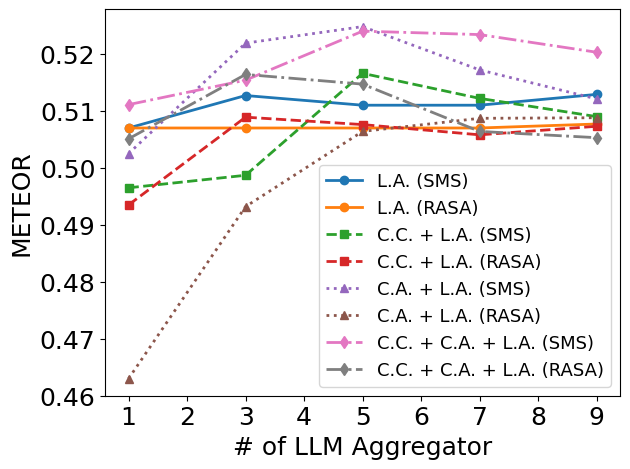

In [ ]:
import matplotlib.pyplot as plt

# Given data
x_values = [1, 3, 5, 7, 9]

# Y values for different categories
la_sms = [0.5070, 0.5127, 0.5110, 0.5110, 0.5129]
la_rasa = [0.5070, 0.5070, 0.5070, 0.5070, 0.5077]
cc_la_sms = [0.4965, 0.4987, 0.5166, 0.5122, 0.5090]
cc_la_rasa = [0.4935, 0.5089, 0.5076, 0.5058, 0.5073]
ca_la_sms = [0.5025, 0.5219, 0.5248, 0.5172, 0.5121]
ca_la_rasa = [0.4630, 0.4932, 0.5064, 0.5087, 0.5088]
cc_ca_la_sms = [0.5111, 0.5154, 0.5240, 0.5234, 0.5203]
cc_ca_la_rasa = [0.5051, 0.5164, 0.5147, 0.5064, 0.5053]

# Create line plots for each category with specified markers and line styles
plt.plot(x_values, la_sms, label='L.A. (SMS)', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, la_rasa, label='L.A. (RASA)', marker='o', linestyle='-', linewidth=2)  # Same marker and line style as 'L.A. (SMS)'
plt.plot(x_values, cc_la_sms, label='C.C. + L.A. (SMS)', marker='s', linestyle='--', linewidth=2)
plt.plot(x_values, cc_la_rasa, label='C.C. + L.A. (RASA)', marker='s', linestyle='--', linewidth=2)  # Same marker and line style as 'C.C. + L.A. (SMS)'
plt.plot(x_values, ca_la_sms, label='C.A. + L.A. (SMS)', marker='^', linestyle=':', linewidth=2)
plt.plot(x_values, ca_la_rasa, label='C.A. + L.A. (RASA)', marker='^', linestyle=':', linewidth=2)  # Same marker and line style as 'C.A. + L.A. (SMS)'
plt.plot(x_values, cc_ca_la_sms, label='C.C. + C.A. + L.A. (SMS)', marker='d', linestyle='-.', linewidth=2)
plt.plot(x_values, cc_ca_la_rasa, label='C.C. + C.A. + L.A. (RASA)', marker='d', linestyle='-.', linewidth=2)  # Same marker and line style as 'C.C. + C.A. + L.A. (SMS)'

# Set y-axis scale
plt.ylim(0.46, None)

# Add labels and legend
plt.xlabel('# of LLM Aggregator', fontsize=18)
plt.ylabel('METEOR', fontsize=18)
plt.legend(fontsize=13)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Ensure tight layout
plt.tight_layout()

# Save the figure
plt.savefig('METEOR_Diff_Num_LLMAgg_J1.pdf')

# Show the plot (optional)
plt.show()

#### J1 Embedding

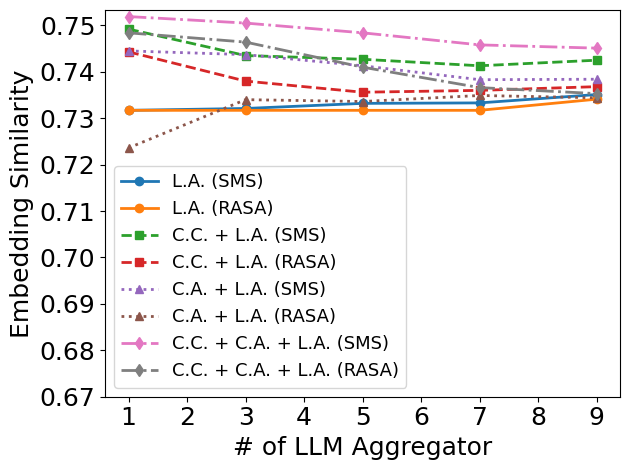

In [ ]:
import matplotlib.pyplot as plt

# Given data
x_values = [1, 3, 5, 7, 9]

# Y values for different categories
la_sms = [0.7317,0.7321,0.7332,0.7333,0.7351]
la_rasa = [0.7317,0.7317,0.7317,0.7317, 0.7341]
cc_la_sms = [0.7492,0.7435,0.7427,0.7413,0.7425]
cc_la_rasa = [0.7443,0.7380,0.7356,0.7360,0.7368]
ca_la_sms = [0.7445,0.7437,0.7413,0.7383,0.7384]
ca_la_rasa = [0.7236,0.7340,0.7336,0.7349,0.7344]
cc_ca_la_sms = [0.7519,0.7505,0.7484,0.7458,0.7451]
cc_ca_la_rasa = [0.7484,0.7464,0.7410,0.7366,0.7353]

# Create line plots for each category with specified markers and line styles
plt.plot(x_values, la_sms, label='L.A. (SMS)', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, la_rasa, label='L.A. (RASA)', marker='o', linestyle='-', linewidth=2)  # Same marker and line style as 'L.A. (SMS)'
plt.plot(x_values, cc_la_sms, label='C.C. + L.A. (SMS)', marker='s', linestyle='--', linewidth=2)
plt.plot(x_values, cc_la_rasa, label='C.C. + L.A. (RASA)', marker='s', linestyle='--', linewidth=2)  # Same marker and line style as 'C.C. + L.A. (SMS)'
plt.plot(x_values, ca_la_sms, label='C.A. + L.A. (SMS)', marker='^', linestyle=':', linewidth=2)
plt.plot(x_values, ca_la_rasa, label='C.A. + L.A. (RASA)', marker='^', linestyle=':', linewidth=2)  # Same marker and line style as 'C.A. + L.A. (SMS)'
plt.plot(x_values, cc_ca_la_sms, label='C.C. + C.A. + L.A. (SMS)', marker='d', linestyle='-.', linewidth=2)
plt.plot(x_values, cc_ca_la_rasa, label='C.C. + C.A. + L.A. (RASA)', marker='d', linestyle='-.', linewidth=2)  # Same marker and line style as 'C.C. + C.A. + L.A. (SMS)'

# Set y-axis scale
plt.ylim(0.67, None)

# Add labels and legend
plt.xlabel('# of LLM Aggregator', fontsize=18)
plt.ylabel('Embedding Similarity', fontsize=18)
plt.legend(fontsize=13)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Ensure tight layout
plt.tight_layout()

# Save the figure
plt.savefig('EmbedSim_Diff_Num_LLMAgg_J1.pdf')

# Show the plot (optional)
plt.show()

#### T1 GLUE

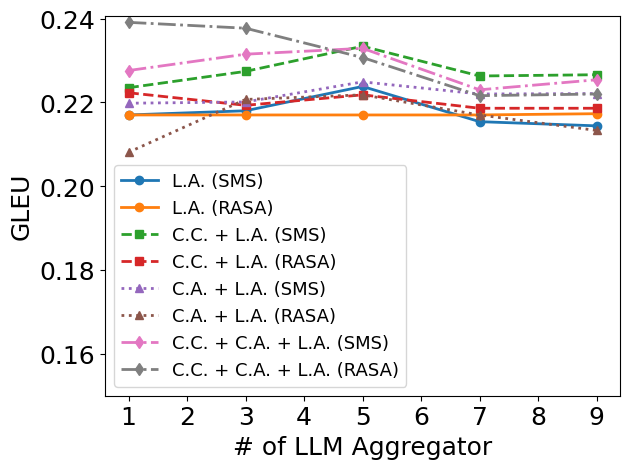

In [ ]:
import matplotlib.pyplot as plt

# Given data
x_values = [1, 3, 5, 7, 9]

# Y values for different categories
la_sms = [0.2170,0.2180,0.2238,0.2154,0.2144]
la_rasa = [0.2170,0.2170,0.2170,0.2170,0.2173]
cc_la_sms = [0.2235,0.2274,0.2334,0.2263,0.2266]
cc_la_rasa = [0.2223,0.2193,0.2218,0.2186,0.2186]
ca_la_sms = [0.2198,0.2201,0.2249,0.2220,0.2221]
ca_la_rasa = [0.2081,0.2207,0.2218,0.2170,0.2133]
cc_ca_la_sms = [0.2276,0.2315,0.2329,0.2230,0.2254]
cc_ca_la_rasa = [0.2391,0.2377,0.2307,0.2216,0.2220]

# Create line plots for each category with specified markers and line styles
plt.plot(x_values, la_sms, label='L.A. (SMS)', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, la_rasa, label='L.A. (RASA)', marker='o', linestyle='-', linewidth=2)  # Same marker and line style as 'L.A. (SMS)'
plt.plot(x_values, cc_la_sms, label='C.C. + L.A. (SMS)', marker='s', linestyle='--', linewidth=2)
plt.plot(x_values, cc_la_rasa, label='C.C. + L.A. (RASA)', marker='s', linestyle='--', linewidth=2)  # Same marker and line style as 'C.C. + L.A. (SMS)'
plt.plot(x_values, ca_la_sms, label='C.A. + L.A. (SMS)', marker='^', linestyle=':', linewidth=2)
plt.plot(x_values, ca_la_rasa, label='C.A. + L.A. (RASA)', marker='^', linestyle=':', linewidth=2)  # Same marker and line style as 'C.A. + L.A. (SMS)'
plt.plot(x_values, cc_ca_la_sms, label='C.C. + C.A. + L.A. (SMS)', marker='d', linestyle='-.', linewidth=2)
plt.plot(x_values, cc_ca_la_rasa, label='C.C. + C.A. + L.A. (RASA)', marker='d', linestyle='-.', linewidth=2)  # Same marker and line style as 'C.C. + C.A. + L.A. (SMS)'

# Set y-axis scale
plt.ylim(0.15, None)

# Add labels and legend
plt.xlabel('# of LLM Aggregator', fontsize=18)
plt.ylabel('GLEU', fontsize=18)
plt.legend(fontsize=13)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Ensure tight layout
plt.tight_layout()

# Save the figure
plt.savefig('GLUE_Diff_Num_LLMAgg_T1.pdf')

# Show the plot (optional)
plt.show()


#### T1 METEOR

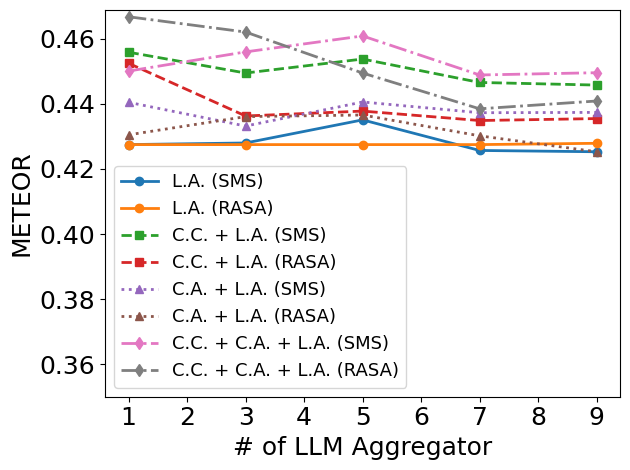

In [ ]:
import matplotlib.pyplot as plt

# Given data
x_values = [1, 3, 5, 7, 9]

# Y values for different categories
la_sms = [0.4275,0.4280,0.4351,0.4257,0.4253]
la_rasa = [0.4275,0.4275,0.4275,0.4275,0.4279]
cc_la_sms = [0.4559,0.4495,0.4538,0.4466,0.4458]
cc_la_rasa = [0.4525,0.4363,0.4378,0.4349,0.4355]
ca_la_sms = [0.4405,0.4332,0.4406,0.4373,0.4374]
ca_la_rasa = [0.4305,0.4361,0.4366,0.4302,0.4253]
cc_ca_la_sms = [0.4501,0.4560,0.4609,0.4489,0.4496]
cc_ca_la_rasa = [0.4668,0.4621,0.4495,0.4385,0.4409]

# Create line plots for each category with specified markers and line styles
plt.plot(x_values, la_sms, label='L.A. (SMS)', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, la_rasa, label='L.A. (RASA)', marker='o', linestyle='-', linewidth=2)  # Same marker and line style as 'L.A. (SMS)'
plt.plot(x_values, cc_la_sms, label='C.C. + L.A. (SMS)', marker='s', linestyle='--', linewidth=2)
plt.plot(x_values, cc_la_rasa, label='C.C. + L.A. (RASA)', marker='s', linestyle='--', linewidth=2)  # Same marker and line style as 'C.C. + L.A. (SMS)'
plt.plot(x_values, ca_la_sms, label='C.A. + L.A. (SMS)', marker='^', linestyle=':', linewidth=2)
plt.plot(x_values, ca_la_rasa, label='C.A. + L.A. (RASA)', marker='^', linestyle=':', linewidth=2)  # Same marker and line style as 'C.A. + L.A. (SMS)'
plt.plot(x_values, cc_ca_la_sms, label='C.C. + C.A. + L.A. (SMS)', marker='d', linestyle='-.', linewidth=2)
plt.plot(x_values, cc_ca_la_rasa, label='C.C. + C.A. + L.A. (RASA)', marker='d', linestyle='-.', linewidth=2)  # Same marker and line style as 'C.C. + C.A. + L.A. (SMS)'

# Set y-axis scale
plt.ylim(0.35, None)

# Add labels and legend
plt.xlabel('# of LLM Aggregator', fontsize=18)
plt.ylabel('METEOR', fontsize=18)
plt.legend(fontsize=13)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Ensure tight layout
plt.tight_layout()

# Save the figure
plt.savefig('METEOR_Diff_Num_LLMAgg_T1.pdf')

# Show the plot (optional)
plt.show()

#### T1 Embedding

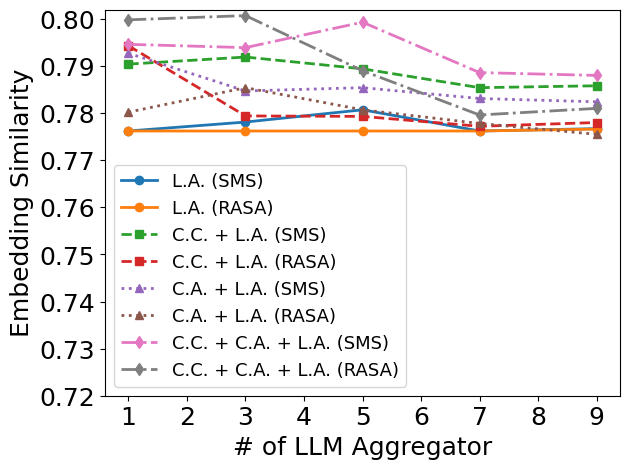

In [ ]:
import matplotlib.pyplot as plt

# Given data
x_values = [1, 3, 5, 7, 9]

# Y values for different categories
la_sms = [0.7762,0.7781,0.7807,0.7762,0.7767]
la_rasa = [0.7762,0.7762,0.7762,0.7762,0.7766]
cc_la_sms = [0.7904,0.7919,0.7894,0.7854,0.7858]
cc_la_rasa = [0.7943,0.7794,0.7793,0.7772,0.7780]
ca_la_sms = [0.7927,0.7847,0.7854,0.7831,0.7824]
ca_la_rasa = [0.7802,0.7854,0.7807,0.7778,0.7755]
cc_ca_la_sms = [0.7946,0.7939,0.7993,0.7886,0.7880]
cc_ca_la_rasa = [0.7998,0.8007,0.7890,0.7796,0.7810]

# Create line plots for each category with specified markers and line styles
plt.plot(x_values, la_sms, label='L.A. (SMS)', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, la_rasa, label='L.A. (RASA)', marker='o', linestyle='-', linewidth=2)  # Same marker and line style as 'L.A. (SMS)'
plt.plot(x_values, cc_la_sms, label='C.C. + L.A. (SMS)', marker='s', linestyle='--', linewidth=2)
plt.plot(x_values, cc_la_rasa, label='C.C. + L.A. (RASA)', marker='s', linestyle='--', linewidth=2)  # Same marker and line style as 'C.C. + L.A. (SMS)'
plt.plot(x_values, ca_la_sms, label='C.A. + L.A. (SMS)', marker='^', linestyle=':', linewidth=2)
plt.plot(x_values, ca_la_rasa, label='C.A. + L.A. (RASA)', marker='^', linestyle=':', linewidth=2)  # Same marker and line style as 'C.A. + L.A. (SMS)'
plt.plot(x_values, cc_ca_la_sms, label='C.C. + C.A. + L.A. (SMS)', marker='d', linestyle='-.', linewidth=2)
plt.plot(x_values, cc_ca_la_rasa, label='C.C. + C.A. + L.A. (RASA)', marker='d', linestyle='-.', linewidth=2)  # Same marker and line style as 'C.C. + C.A. + L.A. (SMS)'

# Set y-axis scale
plt.ylim(0.72, None)

# Add labels and legend
plt.xlabel('# of LLM Aggregator', fontsize=18)
plt.ylabel('Embedding Similarity', fontsize=18)
plt.legend(fontsize=13)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Ensure tight layout
plt.tight_layout()

# Save the figure
plt.savefig('EmbedSim_Diff_Num_LLMAgg_T1.pdf')

# Show the plot (optional)
plt.show()

#### T2 GLEU

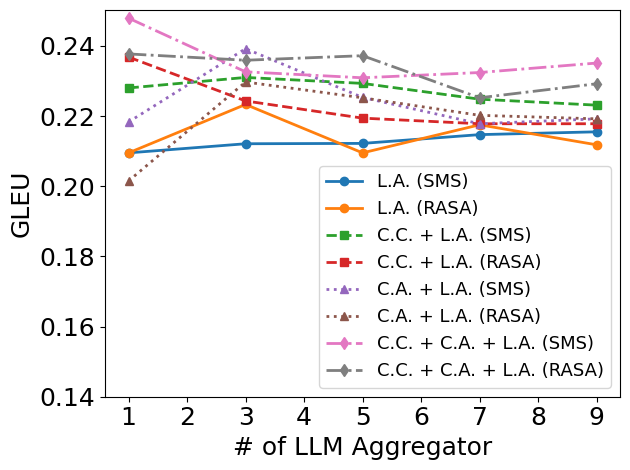

In [ ]:
import matplotlib.pyplot as plt

# Given data
x_values = [1, 3, 5, 7, 9]

# Y values for different categories
la_sms = [0.2095,0.2121,0.2122,0.2147,0.2155]
la_rasa = [0.2095,0.2233,0.2095,0.2175,0.2118]
cc_la_sms = [0.2280,0.2310,0.2293,0.2248,0.2231]
cc_la_rasa = [0.2368,0.2243,0.2194,0.2178,0.2178]
ca_la_sms = [0.2183,0.2392,0.2253,0.2178,0.2192]
ca_la_rasa = [0.2015,0.2297,0.2252,0.2202,0.2192]
cc_ca_la_sms = [0.2479,0.2326,0.2309,0.2324,0.2351]
cc_ca_la_rasa = [0.2377,0.2359,0.2372,0.2252,0.2292]

# Create line plots for each category with specified markers and line styles
plt.plot(x_values, la_sms, label='L.A. (SMS)', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, la_rasa, label='L.A. (RASA)', marker='o', linestyle='-', linewidth=2)  # Same marker and line style as 'L.A. (SMS)'
plt.plot(x_values, cc_la_sms, label='C.C. + L.A. (SMS)', marker='s', linestyle='--', linewidth=2)
plt.plot(x_values, cc_la_rasa, label='C.C. + L.A. (RASA)', marker='s', linestyle='--', linewidth=2)  # Same marker and line style as 'C.C. + L.A. (SMS)'
plt.plot(x_values, ca_la_sms, label='C.A. + L.A. (SMS)', marker='^', linestyle=':', linewidth=2)
plt.plot(x_values, ca_la_rasa, label='C.A. + L.A. (RASA)', marker='^', linestyle=':', linewidth=2)  # Same marker and line style as 'C.A. + L.A. (SMS)'
plt.plot(x_values, cc_ca_la_sms, label='C.C. + C.A. + L.A. (SMS)', marker='d', linestyle='-.', linewidth=2)
plt.plot(x_values, cc_ca_la_rasa, label='C.C. + C.A. + L.A. (RASA)', marker='d', linestyle='-.', linewidth=2)  # Same marker and line style as 'C.C. + C.A. + L.A. (SMS)'

# Set y-axis scale
plt.ylim(0.14, None)

# Add labels and legend
plt.xlabel('# of LLM Aggregator', fontsize=18)
plt.ylabel('GLEU', fontsize=18)
plt.legend(fontsize=13)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Ensure tight layout
plt.tight_layout()

# Save the figure
plt.savefig('GLUE_Diff_Num_LLMAgg_T2.pdf')

# Show the plot (optional)
plt.show()


#### T2 METEOR

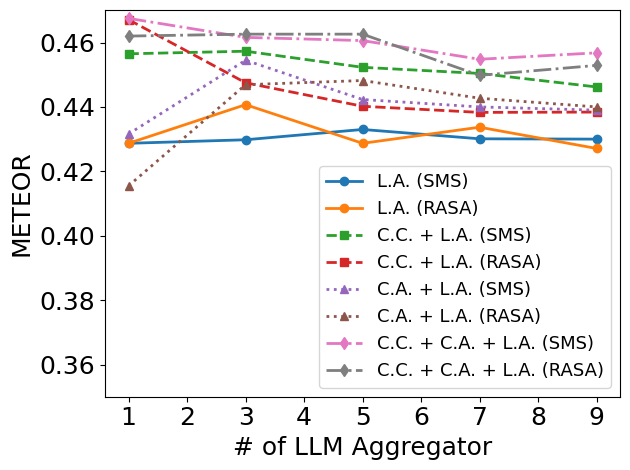

In [ ]:
import matplotlib.pyplot as plt

# Given data
x_values = [1, 3, 5, 7, 9]

# Y values for different categories
la_sms = [0.4287,0.4298,0.4330,0.4301,0.4300]
la_rasa = [0.4287,0.4407,0.4287,0.4337,0.4271]
cc_la_sms = [0.4565,0.4573,0.4523,0.4504,0.4462]
cc_la_rasa = [0.4671,0.4475,0.4402,0.4383,0.4384]
ca_la_sms = [0.4316,0.4545,0.4423,0.4400,0.4390]
ca_la_rasa = [0.4155,0.4469,0.4482,0.4427,0.4400]
cc_ca_la_sms = [0.4675,0.4616,0.4606,0.4548,0.4568]
cc_ca_la_rasa = [0.4620,0.4626,0.4626,0.4498,0.4529]

# Create line plots for each category with specified markers and line styles
plt.plot(x_values, la_sms, label='L.A. (SMS)', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, la_rasa, label='L.A. (RASA)', marker='o', linestyle='-', linewidth=2)  # Same marker and line style as 'L.A. (SMS)'
plt.plot(x_values, cc_la_sms, label='C.C. + L.A. (SMS)', marker='s', linestyle='--', linewidth=2)
plt.plot(x_values, cc_la_rasa, label='C.C. + L.A. (RASA)', marker='s', linestyle='--', linewidth=2)  # Same marker and line style as 'C.C. + L.A. (SMS)'
plt.plot(x_values, ca_la_sms, label='C.A. + L.A. (SMS)', marker='^', linestyle=':', linewidth=2)
plt.plot(x_values, ca_la_rasa, label='C.A. + L.A. (RASA)', marker='^', linestyle=':', linewidth=2)  # Same marker and line style as 'C.A. + L.A. (SMS)'
plt.plot(x_values, cc_ca_la_sms, label='C.C. + C.A. + L.A. (SMS)', marker='d', linestyle='-.', linewidth=2)
plt.plot(x_values, cc_ca_la_rasa, label='C.C. + C.A. + L.A. (RASA)', marker='d', linestyle='-.', linewidth=2)  # Same marker and line style as 'C.C. + C.A. + L.A. (SMS)'

# Set y-axis scale
plt.ylim(0.35, None)

# Add labels and legend
plt.xlabel('# of LLM Aggregator', fontsize=18)
plt.ylabel('METEOR', fontsize=18)
plt.legend(fontsize=13)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Ensure tight layout
plt.tight_layout()

# Save the figure
plt.savefig('METEOR_Diff_Num_LLMAgg_T2.pdf')

# Show the plot (optional)
plt.show()

#### T2 Embedding

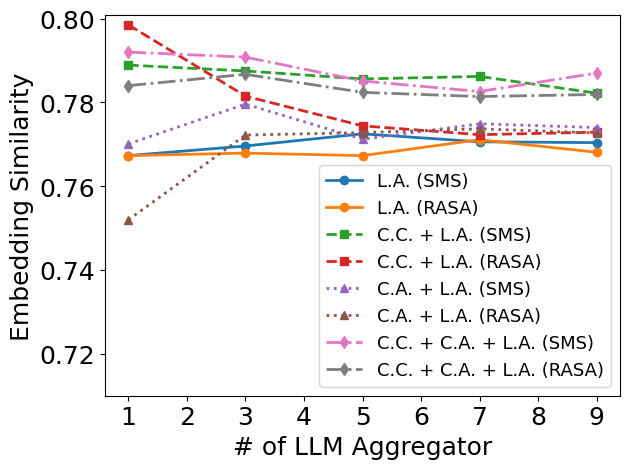

In [ ]:
import matplotlib.pyplot as plt

# Given data
x_values = [1, 3, 5, 7, 9]

# Y values for different categories
la_sms = [0.7673,0.7696,0.7725,0.7706,0.7704]
la_rasa = [0.7673,0.7679,0.7673,0.7711,0.7681]
cc_la_sms = [0.7889,0.7875,0.7856,0.7862,0.7822]
cc_la_rasa = [0.7985,0.7815,0.7744,0.7723,0.7729]
ca_la_sms = [0.7701,0.7796,0.7712,0.7749,0.7740]
ca_la_rasa = [0.7520,0.7722,0.7728,0.7737,0.7727]
cc_ca_la_sms = [0.7920,0.7908,0.7851,0.7826,0.7870]
cc_ca_la_rasa = [0.7840,0.7867,0.7824,0.7814,0.7819]

# Create line plots for each category with specified markers and line styles
plt.plot(x_values, la_sms, label='L.A. (SMS)', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, la_rasa, label='L.A. (RASA)', marker='o', linestyle='-', linewidth=2)  # Same marker and line style as 'L.A. (SMS)'
plt.plot(x_values, cc_la_sms, label='C.C. + L.A. (SMS)', marker='s', linestyle='--', linewidth=2)
plt.plot(x_values, cc_la_rasa, label='C.C. + L.A. (RASA)', marker='s', linestyle='--', linewidth=2)  # Same marker and line style as 'C.C. + L.A. (SMS)'
plt.plot(x_values, ca_la_sms, label='C.A. + L.A. (SMS)', marker='^', linestyle=':', linewidth=2)
plt.plot(x_values, ca_la_rasa, label='C.A. + L.A. (RASA)', marker='^', linestyle=':', linewidth=2)  # Same marker and line style as 'C.A. + L.A. (SMS)'
plt.plot(x_values, cc_ca_la_sms, label='C.C. + C.A. + L.A. (SMS)', marker='d', linestyle='-.', linewidth=2)
plt.plot(x_values, cc_ca_la_rasa, label='C.C. + C.A. + L.A. (RASA)', marker='d', linestyle='-.', linewidth=2)  # Same marker and line style as 'C.C. + C.A. + L.A. (SMS)'

# Set y-axis scale
plt.ylim(0.71, None)

# Add labels and legend
plt.xlabel('# of LLM Aggregator', fontsize=18)
plt.ylabel('Embedding Similarity', fontsize=18)
plt.legend(fontsize=13)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Ensure tight layout
plt.tight_layout()

# Save the figure
plt.savefig('EmbedSim_Diff_Num_LLMAgg_T2.pdf')

# Show the plot (optional)
plt.show()